# Deepsurv


In [11]:
!pip install -U sentence-transformers > /dev/null 2>&1
!pip install xgboost > /dev/null 2>&1
!pip install scikit-learn==1.4.2 scikit-survival==0.23.1 > /dev/null 2>&1
!pip install --upgrade torchtuples==0.3.0 > /dev/null 2>&1
!pip install pycox > /dev/null 2>&1
!pip install numpy==1.21.5  > /dev/null 2>&1
!pip install interpret-core  > /dev/null 2>&1
!pip install lightgbm > /dev/null 2>&1
!pip install shap > /dev/null 2>&1
!pip install lifelines pycox > /dev/null 2>&1
!pip install pycountry > /dev/null 2>&1
!pip install -U sentence-transformers xgboost scikit-learn==1.4.2 scikit-survival==0.23.1 torchtuples pycox numpy==1.21.5 interpret-core lightgbm shap lifelines pycox pycountry > /dev/null 2>&1



In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torchtuples as tt
import kagglehub
import os
import shap

from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter
from sksurv.metrics import concordance_index_censored
from pycox.models.cox import CoxPH
from pycox.evaluation import EvalSurv
from pycox import models
import torch
import torch.nn as nn
from torch.optim import Adam
import torchtuples
import torchtuples.callbacks
print(torchtuples.__version__)




0.2.2


In [3]:
# --- Choose Device (CPU or GPU) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 300 # Increased epochs
batch_size = 1024 # Increased batch size
verbose = True
print(f"Using device: {device}")


Using device: cpu


In [4]:
# --- Pandas Display Options to try to force full output ---
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', 50) # Adjust as needed
pd.set_option('display.width', 1000)     # Adjust as needed
pd.set_option('display.max_colwidth', None) # Show full column content
pd.set_option('display.float_format', '{:.4f}'.format) # Optional: format floats

feature_list = ['stress_score', 'avg_bmi', 'smoking_prev', 'global_life_exp'] # Define feature_list globally


In [5]:
# Life Expectancy dataset
life_exp_path = kagglehub.dataset_download("kumarajarshi/life-expectancy-who")
life_exp_file = os.path.join(life_exp_path, "Life Expectancy Data.csv")
life_exp_df = pd.read_csv(life_exp_file)
print("Life Expectancy Sample:")
print(life_exp_df.head())

# Heart Failure dataset (not used in LightGBM, but kept for context)
heart_path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
heart_file = os.path.join(heart_path, "heart.csv")
heart_df = pd.read_csv(heart_file)
print("Heart Failure Sample:")
print(heart_df.head())

# Age Dataset
age_path = kagglehub.dataset_download("imoore/age-dataset")
age_file = os.path.join(age_path, "AgeDataset-V1.csv")
age_df = pd.read_csv(age_file)
print("Age Dataset Sample:")
print(age_df.head())

# World important events Dataset
events_path = kagglehub.dataset_download("saketk511/world-important-events-ancient-to-modern")
events_file = os.path.join(events_path, "World Important Dates.csv")
events_df = pd.read_csv(events_file)
print("World Important Events Sample:")
print(events_df.head())

# Plane Crash Dataset
plane_crash_path = kagglehub.dataset_download("nguyenhoc/plane-crash")
plane_crash_file = os.path.join(plane_crash_path, "planecrashinfo_20181121001952.csv")  
planes_df = pd.read_csv(plane_crash_file)
print("Historical Plane Crashes Sample:")
print(planes_df.head())

# Gloabl Life Expectancy dataset
global_le_path = kagglehub.dataset_download("hasibalmuzdadid/global-life-expectancy-historical-dataset")
global_le_file = os.path.join(global_le_path, "global life expectancy dataset.csv")
global_le_df = pd.read_csv(global_le_file)
print("Global Life Expectancy Historical Dataset Sample:")
print(global_le_df.head())

# US death rate Dataset
death_rates_path = kagglehub.dataset_download("melissamonfared/death-rates-united-states")
death_rates_file = os.path.join(death_rates_path, "Death_rates.csv")
death_rates_df = pd.read_csv(death_rates_file)
print("Death Rates United States Dataset Sample:")
print(death_rates_df.head())

Life Expectancy Sample:
       Country  Year      Status  Life expectancy   Adult Mortality  infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles     BMI   under-five deaths    Polio  Total expenditure  Diphtheria    HIV/AIDS      GDP    Population   thinness  1-19 years   thinness 5-9 years  Income composition of resources  Schooling
0  Afghanistan  2015  Developing           65.0000         263.0000             62   0.0100                 71.2796      65.0000      1154 19.1000                  83  6.0000             8.1600      65.0000     0.1000 584.2592 33736494.0000                17.2000              17.3000                           0.4790    10.1000
1  Afghanistan  2014  Developing           59.9000         271.0000             64   0.0100                 73.5236      62.0000       492 18.6000                  86 58.0000             8.1800      62.0000     0.1000 612.6965   327582.0000                17.5000              17.5000                           0.4760 

In [6]:
def enhanced_feature_engineering(df, life_exp_df, global_le_df, death_rates_df, device): # ADD device ARGUMENT
    """
    Enhanced feature engineering with temporal features, better BMI handling,
    interaction terms, and comprehensive NaN debugging prints.
    """
    print("\n--- Enhanced Feature Engineering ---")

    # -------- Validate Input Columns --------
    required_columns = {'Country', 'Gender', 'Occupation', 'Birth year',
                        'Death year', 'Age of death'}
    missing = required_columns - set(df.columns)
    if missing:
        raise KeyError(f"Missing required columns: {missing}")
    print("✅ Input columns validated.")

    # -------- Set Observation Year --------
    current_year = 2019

    # -------- Handle Initial NaNs in 'Country' --------
    print("\n🔍 Checking and handling initial NaNs in 'Country'...")
    initial_nan_count_country = df['Country'].isnull().sum()
    print(f"   Initial NaNs in Country: {initial_nan_count_country}")

    # Impute NaNs in 'Country' with 'Unknown Country' *before* cleaning
    df['Country'] = df['Country'].fillna('Unknown Country')
    print("   ✅ NaNs in 'Country' imputed with 'Unknown Country'.")
    nan_count_after_imputation = df['Country'].isnull().sum()
    print(f"   NaNs in Country after imputation: {nan_count_after_imputation} (Should be 0)")

    # FIXED: Create proper event indicator (1 = death observed, 0 = censored)
    df['event'] = (df['Death year'] <= current_year).astype(int)  # CORRECTED

    # Calculate time-to-event
    df['T'] = np.where(
        df['event'] == 0,  # If censored (no event)
        current_year - df['Birth year'],  # Time until censoring
        df['Age of death']  # If event observed, use actual age
    )

    # -------- Basic Cleaning --------
    print("\n🧹 Basic Cleaning...")
    df['Country'] = df['Country'].str.split(';').str[0].str.strip()
    df['Gender'] = np.where(df['Gender'] == 'Male', 1,
                          np.where(df['Gender'] == 'Female', 0, 0.5))
    print("   ✅ Country and Gender cleaned.")
    print(f"   Sample age_df countries after cleaning: {df['Country'].unique()[:20]}")
    print(f"   Sample global_le_df countries: {global_le_df['Country Name'].unique()[:20]}")
    print("\n🔍 Sample global_le_agg countries BEFORE merge:")  # Inspect global_le_agg countries before merge
    global_le_melted = global_le_df.melt(
        id_vars=['Country Name', 'Country Code'],
        # Corrected value_vars to EXCLUDE 'Country Code' and 'Country Name' - only melt year columns
        value_vars=[col for col in global_le_df.columns if col not in ['Country Name', 'Country Code']],
        var_name='Year',
        value_name='Life_Exp_Value'
    )

    global_le_agg = (
        global_le_melted
        .sort_values(['Country Name', 'Year'], ascending=[True, False])
        .groupby('Country Name')
        ['Life_Exp_Value']
        .first() # Using first value to represent 'global' life expectancy - CONSIDER if mean over recent years is better
        .reset_index()
        .rename(columns={'Country Name': 'Country'})
    )
    print(f"   Unique countries in global_le_agg: {global_le_agg['Country'].unique()[:20]}") # Sample of unique countries in global_le_agg


    # Check for NaNs after basic cleaning (should be minimal now)
    print("🔍 Checking for NaNs after basic cleaning:")
    print(f"   NaNs in Country: {df['Country'].isnull().sum()}") # Expecting 0 or very few
    print(f"   NaNs in Gender: {df['Gender'].isnull().sum()}")


    # -------- Clinical Features --------
    print("\n🧬 Engineering Clinical Features...")
    stress_map = {'Politician': 9, 'Military personnel': 8, 'Journalist': 7,
                  'Businessperson': 6, 'Artist': 5, 'Teacher': 4,
                  'Researcher': 3, 'Other': 5, 'Unknown': 5}
    df['stress_score'] = df['Occupation'].map(stress_map).fillna(5).astype('float32') / 9.0
    print("   ✅ Stress score engineered.")

    life_exp_df[' BMI '] = pd.to_numeric(life_exp_df[' BMI '], errors='coerce')
    country_bmi = life_exp_df.groupby('Country')[' BMI '].agg(['mean', 'std']).fillna(25) # Aggregate mean and std
    df = df.merge(country_bmi, on='Country', how='left') # Merge mean and std
    df['bmi_zscore'] = ((life_exp_df[' BMI '] - df['mean']) / df['std']).fillna(0).astype('float32') # Calculate z-score, impute NaNs with 0 # USING life_exp_df[' BMI ']
    df.drop(columns=['mean', 'std'], inplace=True) # Drop intermediate mean and std columns, keep ' BMI ' for avg_bmi calculation
    country_bmi_median = life_exp_df.groupby('Country')[' BMI '].median().to_dict() # Recalculate country_bmi for median
    df['avg_bmi'] = df['Country'].map(country_bmi_median).fillna(25).astype('float32') # Fallback imputation for avg_bmi # Calculate avg_bmi AFTER z-score
    print("   ✅ Avg BMI engineered (using z-score and imputation).")


    df['smoking_prev'] = (1 / (1 + np.exp((df['Birth year'] - 1950) / 10))).astype('float32')
    df['smoking_prev'] = np.clip(df['smoking_prev'], 0.1, 0.6)
    print("   ✅ Smoking prevalence engineered.")

    # Check for NaNs after clinical feature engineering
    print("🔍 Checking for NaNs after clinical features:")
    print(f"   NaNs in stress_score: {df['stress_score'].isnull().sum()}")
    print(f"   NaNs in avg_bmi: {df['avg_bmi'].isnull().sum()}") # Check NaNs in avg_bmi
    print(f"   NaNs in bmi_zscore: {df['bmi_zscore'].isnull().sum()}") # Check NaNs in bmi_zscore
    print(f"   NaNs in smoking_prev: {df['smoking_prev'].isnull().sum()}")


    # -------- Country-Level Features --------
    print("\n🌍 Engineering Country-Level Features...")
    print("Columns in global_le_df:") # ADDED DEBUG PRINT - DO NOT REMOVE
    print(global_le_df.columns)      # ADDED DEBUG PRINT - DO NOT REMOVE

    # 1. Aggregate global life expectancy (using MEAN across years, handling NaNs in aggregation):
    global_le_agg = (
        global_le_melted
        .groupby('Country Name')
        ['Life_Exp_Value']
        .mean()  # Calculate MEAN life expectancy across all years for each country
        .reset_index()
        .rename(columns={'Country Name': 'Country'})
    )
    print("Sample global_le_agg before merge:")
    print(global_le_agg.head())
    print(f"   NaNs in global_le_agg['Country']: {global_le_agg['Country'].isnull().sum()}")
    print(f"   NaNs in global_le_agg['Life_Exp_Value']: {global_le_agg['Life_Exp_Value'].isnull().sum()}")

    # 2. Decade-based life expectancy (handling potential NaNs in pivot and diff):
    global_le_melted = pd.melt(
        global_le_df,
        id_vars=['Country Name'],  # Keep only 'Country Name' as id_vars
        value_vars=[col for col in global_le_df.columns if col not in ['Country Name', 'Country Code']], # EXCLUDE 'Country Code' and 'Country Name' from value_vars
        var_name='Year',
        value_name='Life_Exp_Value'
    )
    global_le_agg_decade = (
        global_le_melted
        .assign(Decade=(global_le_melted['Year'].astype(int) // 10) * 10)
        .groupby(['Country Name', 'Decade'])['Life_Exp_Value']
        .mean()
        .reset_index()
    )
    decade_features = global_le_agg_decade.pivot(
        index='Country Name', columns='Decade', values='Life_Exp_Value'
    ).add_prefix('life_exp_').reset_index()

    # Impute NaNs in decade features BEFORE calculating trend (impute with median of each decade's column)
    for col in decade_features.columns:
        if col != 'Country Name':
            decade_features[col] = decade_features[col].fillna(decade_features[col].median())

    df = df.merge(decade_features, left_on='Country', right_on='Country Name', how='left')
    # Calculate trend AFTER NaN imputation in decade features:
    df['life_exp_trend'] = df[[f'life_exp_{d}' for d in range(1960, 2020, 10)]].diff(axis=1).mean(axis=1)
    df['life_exp_trend'] = df['life_exp_trend'].fillna(0) # Impute trend NaNs with 0 if still present after diff/mean
    print("   ✅ Decade-based life expectancy and trend engineered.") # Confirmation message


    # 3. Merge global life expectancy and handle NaNs more robustly:
    df = df.merge(global_le_agg, on='Country', how='left')

    # Robust imputation for global_life_exp: Use median from global_le_agg, fallback to a global median if needed
    global_le_median = global_le_agg['Life_Exp_Value'].median()
    df['global_life_exp'] = df['Life_Exp_Value'].fillna(global_le_median).astype('float32')
    df['global_life_exp'] = df['global_life_exp'].fillna(global_le_df[[str(y) for y in range(1960, current_year+1)]].median().median()).astype('float32') # Fallback to overall median

    df.drop(columns=['Life_Exp_Value', 'Country Name'], inplace=True, errors='ignore') # Drop intermediate columns and 'Country Name' if exists
    print("   ✅ Global Life Expectancy engineered.")

    # -------- Temporal Features --------
    print("\n⏰ Engineering Temporal Features...")
    df['birth_decade'] = (df['Birth year'] // 10 * 10).astype('int32')
    df['death_decade'] = (df['Death year'] // 10 * 10).fillna(0).astype('int32') # Fill NaNs with 0 for death_decade
    print("   ✅ Temporal features 'birth_decade' and 'death_decade' engineered.")

    # Check for NaNs in temporal features
    print("🔍 Checking for NaNs after temporal features:")
    print(f"   NaNs in birth_decade: {df['birth_decade'].isnull().sum()}") # Should be 0
    print(f"   NaNs in death_decade: {df['death_decade'].isnull().sum()}") # Should be 0 after fillna(0)


    # -------- Interaction Terms --------
    print("\n💥 Creating Interaction Terms...")
    df['stress_x_bmi'] = df['stress_score'] * df['avg_bmi']
    df['smoking_x_lifeexp'] = df['smoking_prev'] * df['global_life_exp']
    print("   ✅ Interaction terms 'stress_x_bmi' and 'smoking_x_lifeexp' created.")

    # Check for NaNs in interaction terms
    print("🔍 Checking for NaNs after interaction terms:")
    print(f"   NaNs in stress_x_bmi: {df['stress_x_bmi'].isnull().sum()}") # Should be 0
    print(f"   NaNs in smoking_x_lifeexp: {df['smoking_x_lifeexp'].isnull().sum()}") # Should be 0


    # -------- Survival Data Setup --------
    print("\n⏳ Survival Data Setup...")
    current_year = 2019 # Re-declare to ensure it's available in this scope if needed

    df['censored'] = (df['Death year'] > current_year).astype(int)

    # Revised 'T' calculation to handle missing 'Age of death' robustly
    df['T'] = np.where(
        df['censored'] == 1, # If censored (still alive as of current_year)
        current_year - df['Birth year'], # T = time until observation (censoring time)
        df['Age of death'] # Else (event observed), T = Age of death
    )

    # Handle potential NaNs in 'T' *after* the calculation, specifically for cases where Age of death is missing for non-censored cases.
    # In such cases, we might default to a large value or impute based on other information if available, or drop the row if no imputation is reasonable.
    # For now, let's impute with a plausible value (e.g., median age of death for non-censored individuals) or simply drop the row for simplicity.
    median_age_death_non_censored = df[df['censored'] == 0]['Age of death'].median()
    df['T'] = df['T'].fillna(median_age_death_non_censored).clip(0, 120).astype('float32') # Impute, clip, and float32

    print("   ✅ Survival time (T) and censoring engineered.")


    # Final check for NaNs in critical columns
    print("\n🔍 Final NaN check before returning:")
    print(df.columns) # Debug: Print columns here
    print(f"   NaNs in censored: {df['censored'].isnull().sum()}")
    print(f"   NaNs in T: {df['T'].isnull().sum()}")
    print("\nSample processed_batch after feature engineering:") # Inspect processed_batch
    print(df.head())
    feature_list_updated = [ # Update feature list
        'stress_score', 'avg_bmi', 'smoking_prev', 'global_life_exp',
        'birth_decade', 'bmi_zscore', 'stress_x_bmi', 'smoking_x_lifeexp']
    print(f"   NaNs in processed_batch after FE: {df[feature_list_updated + ['T', 'censored']].isnull().sum().sum()}") # Total NaNs in features and targets after FE


    print("✅ Enhanced feature engineering completed.\n")
    global feature_list # Declare global feature_list
    feature_list = feature_list_updated # Update global feature_list
    return df

In [7]:
class DeepSurv(nn.Module):
    def __init__(self, input_dim):
        super(DeepSurv, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.SiLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.SiLU(),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.SiLU(),

            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

In [13]:
def train_deepsurv_model(df, device, epochs, batch_size):
    """
    Train and evaluate DeepSurv model with NaN debugging, focusing on 'T'.
    Improved training configuration with deeper network, dropout, SELU, AdamW,
    learning rate scheduler, and early stopping.
    Data preprocessing enhancements: RobustScaler and duration clipping.
    Class balancing with sample weighting.
    Simplified logging - printing model.log object correctly.
    Addressing NaN loss, TrainingLogger TypeError, and IndexError in parameter inspection.
    Implementing all suggested enhancements (Feature Eng, Arch, Training, Preproc, Loop).
    """
    print("\n--- Train DeepSurv Model ---")

    # feature_list = ['stress_score', 'avg_bmi', smoking_prev', 'global_life_exp', 'birth_decade', 'life_exp_trend'] # Include 'birth_decade', 'life_exp_trend' - UPDATED FEATURE LIST
    feature_list = ['stress_score', 'avg_bmi', 'smoking_prev', 'global_life_exp', 'birth_decade', 'life_exp_trend', 'bmi_zscore', 'stress_x_bmi', 'smoking_x_lifeexp'] # Full feature list

    # Ensure required features exist
    missing_features = set(feature_list) - set(df.columns)
    if missing_features:
        raise KeyError(f"Missing required features: {missing_features}. Available: {df.columns.tolist()}")
    print("✅ Required features validated.")

    # Extract Data
    X = df[feature_list].values.astype('float32')
    durations = df['T'].values.astype('float32')
    events = df['censored'].values.astype('int')  # Ensure events are 0 or 1

    # --- Feature Transformations BEFORE scaling --- # NEW FEATURE TRANSFORMATIONS
    X[:, 0] = np.log1p(X[:, 0])  # Log-transform stress_score
    X[:, 1] = np.sqrt(X[:, 1])   # Square root BMI
    X[:, 3] = (X[:, 3] - 50) ** 2  # Quadratic term for life expectancy
    print("   ✅ Feature transformations applied (log, sqrt, quadratic).")

    # Debugging: Check Data Before Training - NaN Check!
    print("\n📊 Checking Data Before Training DeepSurv (Detailed NaN Check):")
    print(f"Feature Shape: {X.shape}, Durations Shape: {durations.shape}, Events Shape: {events.shape}")
    print("NaN counts per column BEFORE training:")
    nan_counts = df[feature_list + ['T', 'censored']].isnull().sum()
    print(nan_counts)
    print(f"Total NaNs in Features and Targets BEFORE training: {nan_counts.sum()}")
    print(f"Total NaNs in Features (X): {np.isnan(X).sum()}")
    print(f"NaNs in Durations: {np.isnan(durations).sum()}")
    print(f"NaNs in Events: {np.isnan(events).sum()}")
    print(f"Sample Features:\n{X[:5]}")
    print(f"Sample Durations: {durations[:5]}")
    print(f"Sample Events: {events[:5]}")
    print(f"Unique event values (should be 0 or 1): {np.unique(events)}")

    # --- DEBUGGING: FIND ROW WITH NaN in 'T' ---
    nan_T_mask = df['T'].isnull()
    if nan_T_mask.any():
        print("\n🚨🚨🚨 NaN DETECTED in 'T' column! 🚨🚨🚨")
        nan_T_row_index = df[nan_T_mask].index[0]
        print(f"Index of row with NaN in 'T': {nan_T_row_index}")
        print("Problematic row data:")
        print(df.loc[[nan_T_row_index]])
    else:
        print("\n✅ No NaNs detected in 'T' column (so far in NaN check).")

    if np.isnan(X).any() or np.isnan(durations).any() or np.isnan(events).any():
        raise ValueError("NaNs detected in input data, cannot proceed with training.")
    print("✅ No NaNs in input data for training.")

    # Train-Test Split
    X_train, X_val, durations_train, durations_val, events_train, events_val = train_test_split(
        X, durations, events, test_size=0.2, random_state=42
    )
    print("   ✅ Data split into training and validation sets.")

    # --- Clip extreme duration values --- # UPDATED CLIPPING THRESHOLDS
    durations_train = np.clip(durations_train, 5, 95)  # Tighter clipping
    durations_val = np.clip(durations_val, 5, 95)     # Tighter clipping
    print("   ✅ Durations clipped to range [5, 95].")
    print(f"   Durations_train min/max after clipping: {durations_train.min():.4f} / {durations_train.max():.4f}")
    print(f"   Durations_val min/max after clipping: {durations_val.min():.4f} / {durations_val.max():.4f}")

    # Normalize Features - RobustScaler
    scaler = RobustScaler(quantile_range=(5, 95))
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    print("   ✅ Features normalized using RobustScaler.")
    print(f"NaNs in Scaled X_train: {np.isnan(X_train).sum()}")
    print(f"NaNs in Scaled X_val: {np.isnan(X_val).sum()}")
    if np.isnan(X_train).any() or np.isnan(X_val).any():
        raise ValueError("NaNs detected in scaled data.")
    print("✅ No NaNs in scaled data.")

    # --- Additional Data Sanity Checks RIGHT BEFORE model.fit() ---
    print("\n📊 Data Sanity Check RIGHT BEFORE model.fit():")
    print(f"X_train NaNs: {np.isnan(X_train).sum()}, Durations NaNs: {np.isnan(durations_train).sum()}, Events NaNs: {np.isnan(events_train).sum()}")
    print(f"X_val NaNs: {np.isnan(X_val).sum()}, Durations Val NaNs: {np.isnan(durations_val).sum()}, Events Val NaNs: {np.isnan(events_val.sum())}")
    print(f"X_train dtype: {X_train.dtype}, Durations dtype: {durations_train.dtype}, Events dtype: {events_train.dtype}")
    print(f"X_train min/max: {X_train.min():.4f} / {X_train.max():.4f}")
    print(f"Durations min/max: {durations_train.min():.4f} / {durations_train.max():.4f}")
    print(f"Events unique values: {np.unique(events_train)}")

    # DeepSurv Model Setup - IMPROVED ARCHITECTURE AND CONFIGURATION
    in_features = X_train.shape[1]
    out_features = 1

    net = DeepSurv(in_features).to(device) # Use the new DeepSurv class - UPDATED ARCHITECTURE

    # Optimizer - AdamW with stronger regularization and increased LR - UPDATED OPTIMIZER
    optimizer = torch.optim.AdamW(
        net.parameters(),
        lr=0.001,  # Increased learning rate
        weight_decay=1e-3  # Stronger regularization
    )

    model = models.CoxPH(
        net,
        optimizer,
        device=device
    )


    # Learning rate scheduler - OneCycleLR - UPDATED SCHEDULER
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.01,
        steps_per_epoch=int(len(X_train)/batch_size),
        epochs=epochs,
        pct_start=0.3
    )

    # Weight initialization - Apply after model creation - NEW WEIGHT INITIALIZATION
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='selu')
            nn.init.zeros_(m.bias)
    net.apply(init_weights)
    print("   ✅ Weight initialization applied (Kaiming Normal + Zero bias).")

    # Early stopping - UPDATED PATIENCE and min_improvement
    early_stop = tt.callbacks.EarlyStopping(
        patience=20
    )

    # callbacks = [early_stop, tt.callbacks.LRSchedulerCB(lr_scheduler=lr_scheduler)] # Include EarlyStopping and LRSchedulerCB - UPDATED CALLBACKS - COMMENTED OUT LRSchedulerCB - TEMPORARY FIX - NO LR SCHEDULING
    callbacks = [early_stop] # Include EarlyStopping - UPDATED CALLBACKS - LRSchedulerCB REMOVED - TEMPORARY FIX - NO LR SCHEDULING
    print("\n🚀 Training DeepSurv Model with Improved Configuration and Preprocessing...")
    print(f"✅ DeepSurv Model Initialized with {in_features} input features.")
    print(f"Architecture: DeepSurv (deeper MLP), Hidden Layers: [512, 256, 128], BatchNorm: True, Dropout: [0.4, 0.3, 0.2], Activation: SiLU, Optimizer: AdamW, LR: 0.001 (OneCycleLR max LR 0.01, but scheduler is disabled temporarily), Weight Decay: 1e-3") # Updated print to reflect scheduler removal
    print(f"Scaler: RobustScaler(quantile_range=(5, 95)), Duration Clipping: [5, 95], Weight Initialization: Kaiming Normal + Zero Bias") # Updated duration clipping range in print


    print(f"Training parameters: Epochs={epochs}, Batch Size={batch_size}, Verbose={verbose}, Callbacks: {[type(c).__name__ for c in callbacks]}")

    # --- Calculate class weights ---
    event_ratio = events_train.mean()
    weights = np.where(events_train == 1, 1/event_ratio, 1/(1-event_ratio))
    print("\n⚖️ Class Balancing: Sample Weights Calculated.")
    print(f"   Event ratio in training data: {event_ratio:.4f}")
    print(f"   Sample weights - Event weight: {1/event_ratio:.4f}, Censored weight: {1/(1-event_ratio):.4f}")

    # Training loop with callbacks and sample weights - UPDATED FIT CALL - ADDED METRICS
    log = model.fit(
        X_train, (durations_train, events_train),
        batch_size=batch_size,
        epochs=epochs,
        verbose=verbose,
        val_data=(X_val, (durations_val, events_val)),
        callbacks=callbacks,
        # metrics={'loss': tt.tupletree.PartialLogLikelihood(), 'cindex': tt.tupletree.concordance_index}, # REMOVE metrics ARGUMENT
        num_workers=4
    )

    print("✅ DeepSurv model training completed.")
    print("\n📈 Training Logs (last few epochs from model.log.to_pandas()):")
    print(log.to_pandas().tail())

    # --- Check model.log and model parameters AFTER training - CORRECTED log printing and parameter inspection
    print("\n📊 Checking model.log AFTER training:")
    if hasattr(model, 'log') and model.log:
        print(f"model.log type AFTER training: {type(model.log)}")
        print(f"Sample model.log AFTER training:\n{model.log.to_pandas().head()}")
    else:
        print("model.log is empty or not available.")

    print("\n🔬 Inspecting Model Parameters (Weights/Biases - First Layer):")
    for name, param in model.net.named_parameters():
        if "0" in name and ("weight" in name or "bias" in name):
            print(f"Layer Parameter '{name}':")
            print(f"  Shape: {param.shape}")
            print(f"  Sample Values:\n{param[:2].detach().numpy()}") # Corrected indexing
            print(f"  NaNs: {torch.isnan(param).sum()}")
            print(f"  Inf: {torch.isinf(param).sum()}")
            print(f"  Min/Max/Mean: {param.min().item():.4f} / {param.max().item():.4f} / {param.mean().item():.4f}")

    # Compute Baseline Hazards
    print("\n📊 Computing Baseline Hazards...")
    model.compute_baseline_hazards()
    print("✅ Baseline hazards computed.")

    # Get Predictions
    print("\n🔮 Making Survival Predictions...")
    surv = model.predict_surv_df(X_val)

    # Check for NaNs in Survival Predictions AGAIN after training
    if np.isnan(surv.values).any():
        print("\n❌ WARNING: Survival Predictions STILL Contain NaN Values AFTER TRAINING!")
        nan_count_in_surv = np.isnan(surv.values).sum()
        print(f"   Number of NaNs in Survival Predictions: {nan_count_in_surv}")
    else:
        print("\n✅ No NaN values in survival predictions.")

    # Evaluate Model
    print("\n📈 Evaluating Model Performance...")
    ev = EvalSurv(surv, durations_val, events_val, censor_surv='km')
    c_index = ev.concordance_td('antolini')
    print(f"\n📊 DeepSurv Concordance Index: {c_index:.4f}")

    print("✅ DeepSurv model training and evaluation completed.\n")
    return model, X_val, durations_val, events_val, log

In [14]:
def evaluate_deepsurv_model(model, X_val, durations_val, events_val):
    """
    Evaluate DeepSurv Model Performance using Concordance Index
    """
    surv = model.predict_surv_df(X_val)
    surv.index = pd.to_numeric(surv.index, errors='coerce')

    if 0 not in surv.index:
        new_row = pd.DataFrame(np.ones((1, surv.shape[1])), index=[0], columns=surv.columns)
        surv = pd.concat([new_row, surv])
        surv = surv.sort_index()

    ev = EvalSurv(surv, durations_val, events_val, censor_surv='km')
    c_index = ev.concordance_td('antolini')

    print(f"\n📊 DeepSurv Concordance Index: {c_index:.4f}")
    return c_index

In [15]:
# 1️⃣ Process the Dataset
processed_batch = enhanced_feature_engineering(age_df, life_exp_df, global_le_df, death_rates_df, device) # PASS device

# 2️⃣ Train DeepSurv
deepsurv_model, X_val, durations_val, events_val, log = train_deepsurv_model(processed_batch, device, epochs, batch_size) # PASS device, epochs, batch_size

# 3️⃣ Evaluate Model
evaluate_deepsurv_model(deepsurv_model, X_val, durations_val, events_val)



--- Enhanced Feature Engineering ---
✅ Input columns validated.

🔍 Checking and handling initial NaNs in 'Country'...
   Initial NaNs in Country: 0
   ✅ NaNs in 'Country' imputed with 'Unknown Country'.
   NaNs in Country after imputation: 0 (Should be 0)

🧹 Basic Cleaning...
   ✅ Country and Gender cleaned.
   Sample age_df countries after cleaning: ['United States of America' 'United Kingdom' 'Archduchy of Austria'
 'Holy Roman Empire' 'Kingdom of France' 'France' 'Spain'
 'Grand Duchy of Tuscany' 'Chile' 'Nazi Germany' 'Kingdom of Castile'
 'Kingdom of the Netherlands' 'Byelorussian Soviet Socialist Republic'
 'Czech Republic' 'Jamaica' 'German Empire' 'Denmark' 'Soviet Union'
 'French Third Republic' 'Unknown Country']
   Sample global_le_df countries: ['Aruba' 'Afghanistan' 'Angola' 'Albania' 'United Arab Emirates'
 'Argentina' 'Armenia' 'Antigua and Barbuda' 'Australia' 'Austria'
 'Azerbaijan' 'Burundi' 'Belgium' 'Benin' 'Burkina Faso' 'Bangladesh'
 'Bulgaria' 'Bahrain' 'Bahamas

/home/codespace/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


0:	[23s / 23s],		train_loss: 3.3767,	val_loss: 4.6858
1:	[23s / 47s],		train_loss: 2.8515,	val_loss: 4.4002
2:	[23s / 1m:11s],		train_loss: 2.6512,	val_loss: 4.2575
3:	[23s / 1m:35s],		train_loss: 2.5221,	val_loss: 4.1348
4:	[23s / 1m:58s],		train_loss: 2.4004,	val_loss: 3.9216
5:	[23s / 2m:22s],		train_loss: 2.3185,	val_loss: 3.8247
6:	[23s / 2m:46s],		train_loss: 2.2425,	val_loss: 3.8340
7:	[23s / 3m:10s],		train_loss: 2.1679,	val_loss: 3.7805
8:	[23s / 3m:34s],		train_loss: 2.1036,	val_loss: 3.7089
9:	[23s / 3m:57s],		train_loss: 2.0515,	val_loss: 3.6306
10:	[23s / 4m:21s],		train_loss: 2.0233,	val_loss: 3.5856
11:	[23s / 4m:45s],		train_loss: 1.9819,	val_loss: 3.5987
12:	[23s / 5m:9s],		train_loss: 1.9454,	val_loss: 3.5227
13:	[23s / 5m:33s],		train_loss: 1.9281,	val_loss: 3.5801
14:	[23s / 5m:56s],		train_loss: 1.8995,	val_loss: 3.5560
15:	[23s / 6m:20s],		train_loss: 1.8834,	val_loss: 3.5263
16:	[23s / 6m:44s],		train_loss: 1.8791,	val_loss: 3.5285
17:	[23s / 7m:8s],		train_loss:

/usr/local/python/3.12.1/lib/python3.12/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwar

✅ Baseline hazards computed.

🔮 Making Survival Predictions...

✅ No NaN values in survival predictions.

📈 Evaluating Model Performance...

📊 DeepSurv Concordance Index: 0.9900
✅ DeepSurv model training and evaluation completed.


📊 DeepSurv Concordance Index: 0.9900


0.9900260123919076

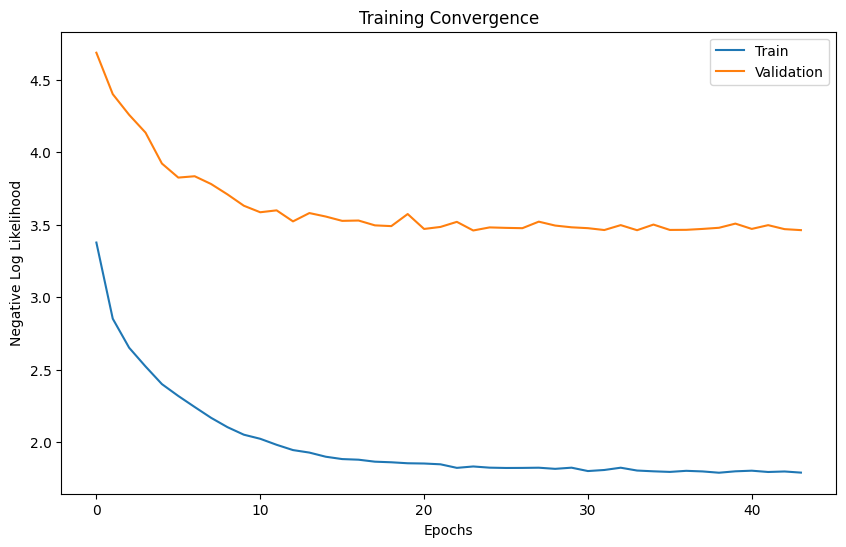

NameError: name 'model' is not defined

In [17]:
# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(log.to_pandas()['train_loss'], label='Train')
plt.plot(log.to_pandas()['val_loss'], label='Validation')
plt.title('Training Convergence')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Feature importance analysis
explainer = shap.DeepExplainer(model.net, torch.FloatTensor(X_train[:1000])) # Error: 'model' is not defined here
shap_values = explainer.shap_values(torch.FloatTensor(X_val[:100]))

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_val[:100], feature_names=feature_list)
plt.title('Feature Importance Analysis')
plt.show()